# Importing the necessary libraries

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import numpy as np
import kagglehub
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
import scipy.stats as stats
from sklearn import preprocessing

In [5]:
# Download the dataset 
path = kagglehub.dataset_download("krishnaraj30/finance-loan-approval-prediction-data")

print("Path to dataset files:", path)

Path to dataset files: /Users/sangeetasaha/.cache/kagglehub/datasets/krishnaraj30/finance-loan-approval-prediction-data/versions/1


In [6]:
# List all files in the directory
files = os.listdir(path)
print("Files in dataset:", files)

# Read the CSV file (assuming there's a CSV file)
csv_file = [f for f in files if f.endswith('.csv')]  # Get the first CSV file
test = pd.read_csv(os.path.join(path, csv_file[0]))
train = pd.read_csv(os.path.join(path, csv_file[1]))


Files in dataset: ['test.csv', 'train.csv']


In [7]:
# Display the dataframe
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [9]:
# Adding an extra column for total income
train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
 13  TotalIncome        614 non-null    float64
dtypes: float64(5), int64(1), object(8)
memory usage: 67.3+ KB


## Handling Missing Values

To ensure the dataset is complete and ready for analysis, we replace the missing values based on logical assumptions and the nature of the data:

- **Married**  
  Missing values are filled with `"No"`, assuming that if the information is missing, the applicant might not be married.

- **Dependents**  
  Missing values are replaced with `0`, treating missing dependent information as having no dependents.

- **Self_Employed**  
  Missing entries are filled with `"No"`, under the assumption that most applicants are not self-employed unless specified.

- **Loan_Amount_Term**  
  Missing values are replaced with the **mode** of the column, as the most common term length is likely the default choice for applicants.

- **Credit_History**  
  Missing credit history information is replaced with `0`, indicating no available credit history.

- **LoanAmount**  
  Instead of using a general mean or median, missing values are filled with the **average LoanAmount corresponding to each specific Loan_Amount_Term**.  
  This approach maintains consistency because the loan term length typically influences the loan amount.


In [11]:
loan_amount_term_dictionary = train.groupby(['Loan_Amount_Term'])['LoanAmount'].mean().astype(int).to_dict()
loan_amount_term_dictionary

{12.0: 111,
 36.0: 117,
 60.0: 140,
 84.0: 132,
 120.0: 22,
 180.0: 147,
 240.0: 118,
 300.0: 185,
 360.0: 147,
 480.0: 151}

In [24]:
# Handling missing data
train['Gender'] = train['Gender'].fillna(train['Gender'].mode()[0])
train['Married'] = train['Married'].fillna('No')
train['Dependents'] = train['Dependents'].fillna('0')
train['Self_Employed'] = train['Self_Employed'].fillna('No')
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0])
train['Credit_History'] = train['Credit_History'].fillna(0)
train['LoanAmount'] = train.apply(lambda row: loan_amount_term_dictionary.get(row['Loan_Amount_Term']) if pd.isna(row['LoanAmount']) else row['LoanAmount'],
    axis=1)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
 13  TotalIncome        614 non-null    float64
dtypes: float64(5), int64(1), object(8)
memory usage: 67.3+ KB


## EDA

### Count plots for each categorical variable

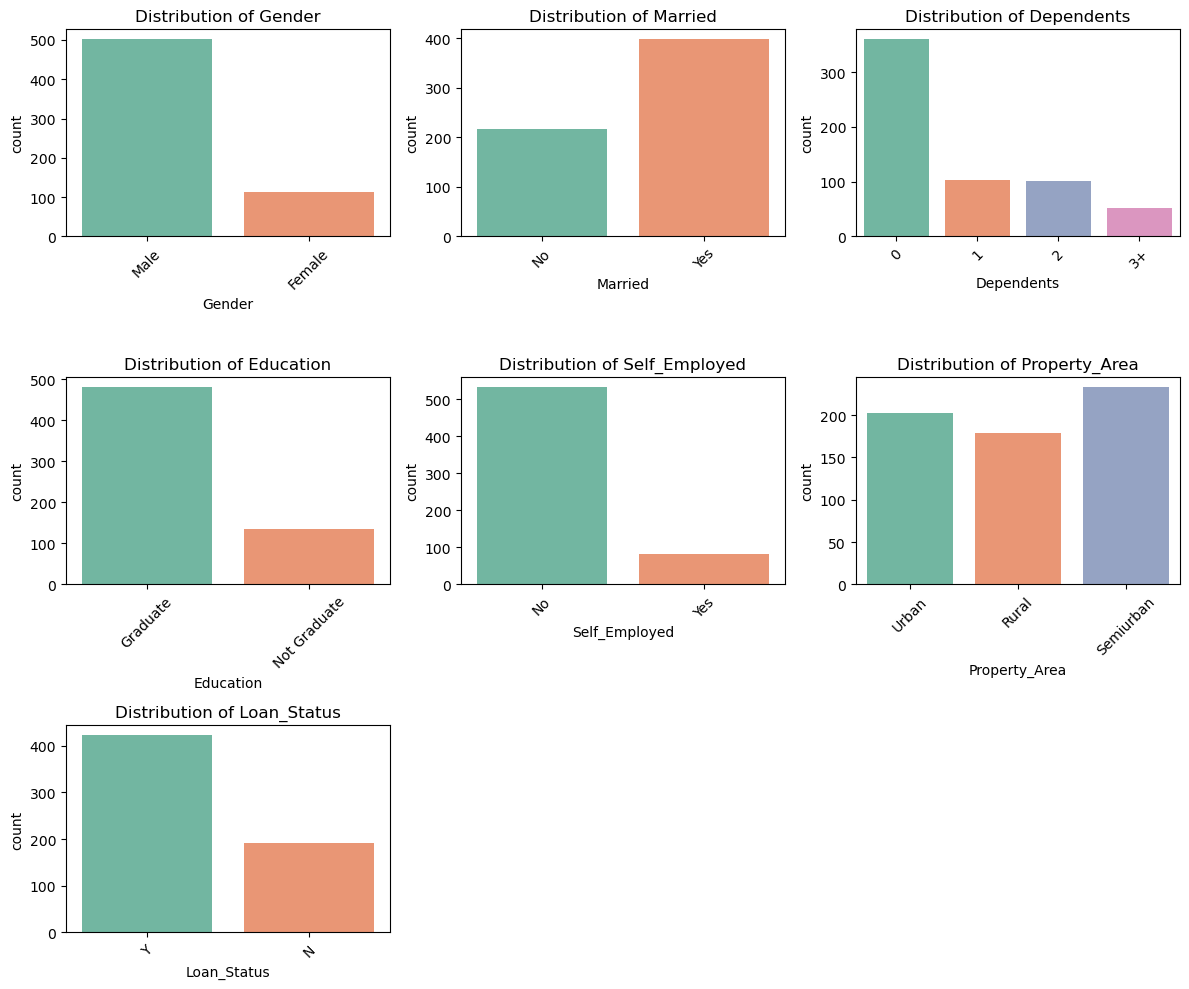

In [26]:
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

# Plot count plots for each categorical variable
plt.figure(figsize=(12, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=train[col], palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()


### Distribution of Loan Status Across Categorical Features

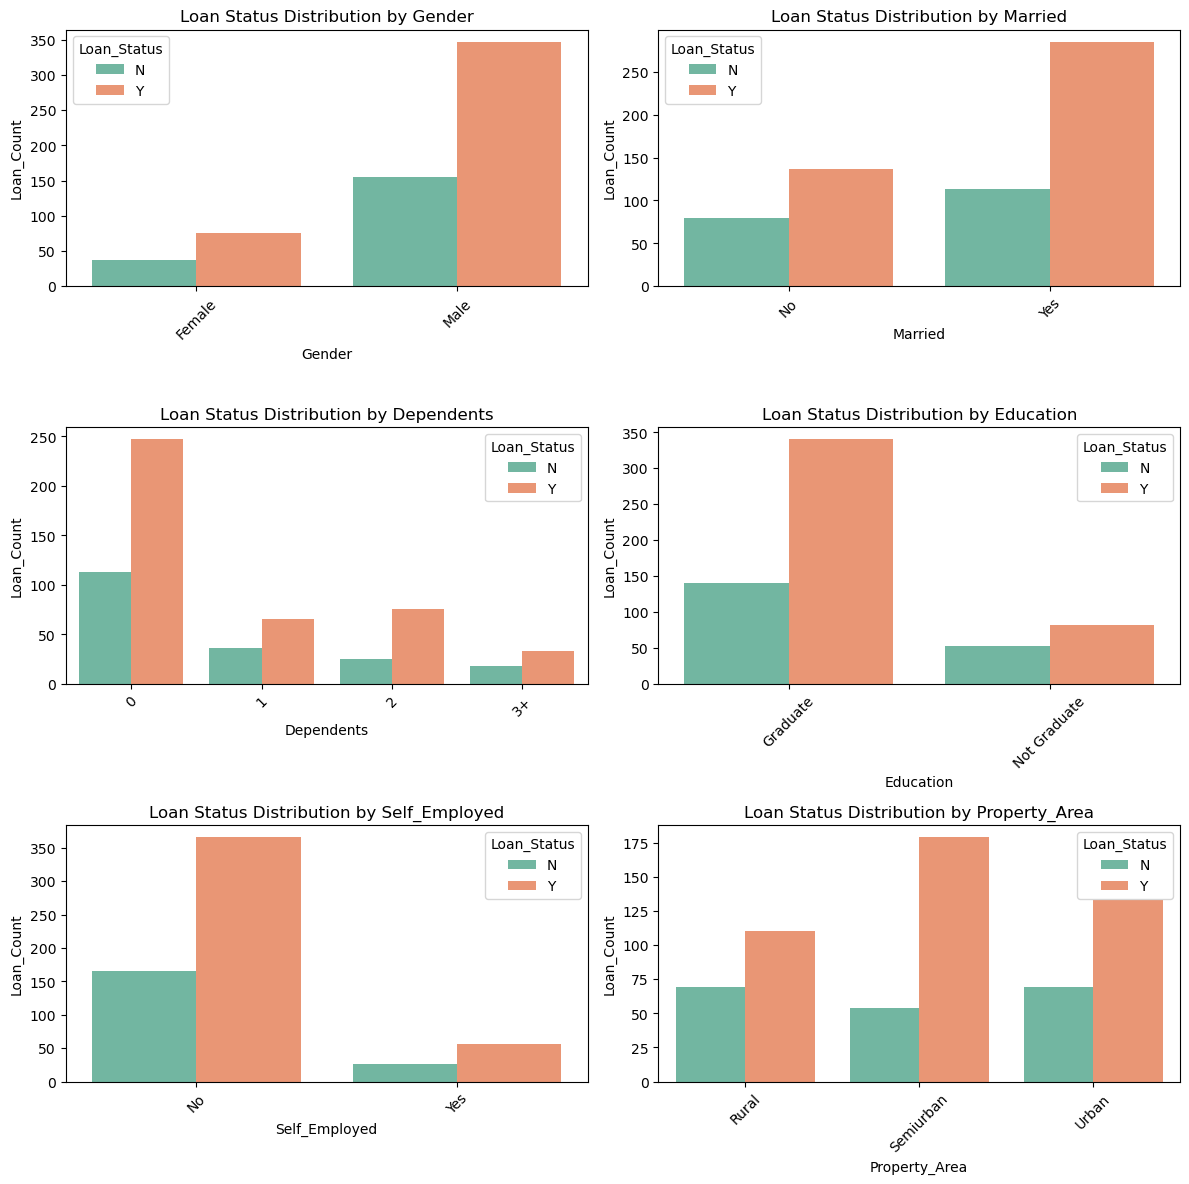

In [27]:
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


# Group by each categorical column and Loan_Status to get counts and plot
plt.figure(figsize=(12, 15))
for i, col in enumerate(categorical_cols, 1):
    grouped_df = train.groupby([col, 'Loan_Status'])['Loan_Status'].count().reset_index(name='Loan_Count')
    
    plt.subplot(4, 2, i)
    sns.barplot(x=col, y='Loan_Count', hue='Loan_Status', data=grouped_df, palette='Set2')
    plt.title(f'Loan Status Distribution by {col}')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

### Summary statistics of numerical data

In [28]:

numerical_data = train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']]
numerical_data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,146.385993,342.410423
std,6109.041673,2926.248369,84.045369,64.428629
min,150.000000,0.000000,9.000000,12.000000
25%,2877.500000,0.000000,100.250000,360.000000
50%,3812.500000,1188.500000,128.500000,360.000000
75%,5795.000000,2297.250000,164.750000,360.000000
max,81000.000000,41667.000000,700.000000,480.000000


### Correlation Analysis of numerical variables
 
To understand the relationships between numerical features in the dataset, we use the `.corr()` method.

The `.corr()` method calculates **pairwise correlation coefficients** between numerical columns using the **Pearson correlation** by default.  
It measures the **linear relationship** between variables based on **covariance**, not on distance metrics like Euclidean distance. The resulting values range from **–1 to +1**, indicating the strength and direction of the linear relationship between variables.


<Axes: >

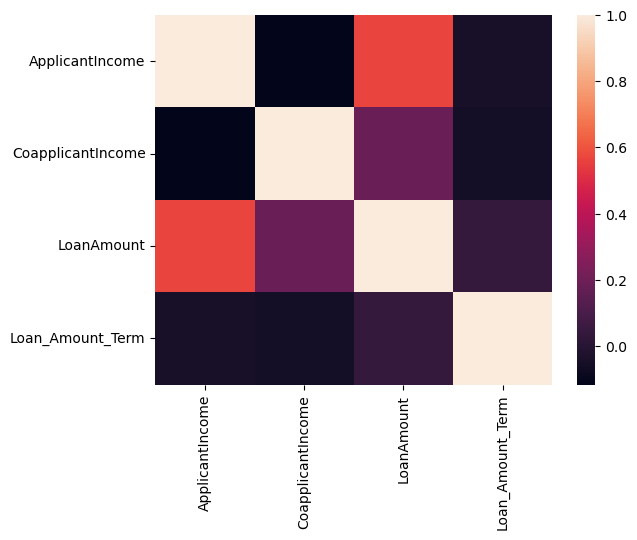

In [29]:
# Find the correlation between the numerical data

corr = numerical_data.corr()
sns.heatmap(corr)

/var/folders/pd/_qgptw4116qd3yy48lzsvp400000gn/T/ipykernel_4771/1008157791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_data['TotalIncome'] = numerical_data['ApplicantIncome'] + numerical_data['CoapplicantIncome']


<Axes: >

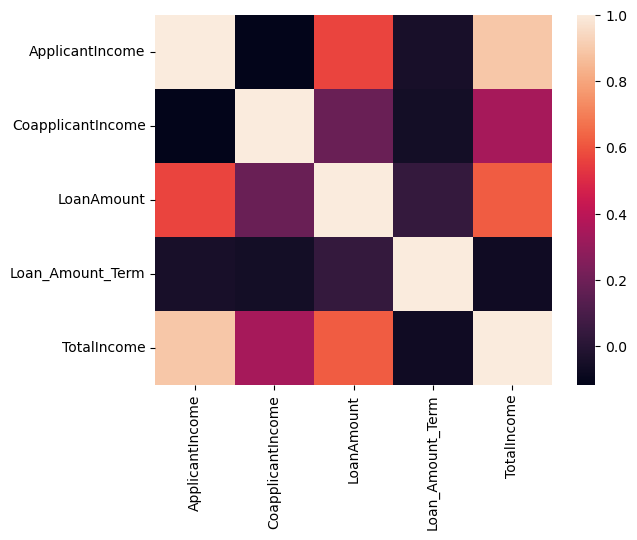

In [30]:
# checking the correlation between the total income(applicant income + coapplicant income) and other numerical variables

numerical_data['TotalIncome'] = numerical_data['ApplicantIncome'] + numerical_data['CoapplicantIncome']
corr = numerical_data.corr()
sns.heatmap(corr)

### Association Analysis for Categorical Variables

To understand the relationships between categorical features in the dataset, we use a **Cramér's V matrix**.

Cramér's V measures the **strength of association** between two categorical variables.  
It is based on the **chi-squared statistic** and returns values between **0 and 1**, where:
- **0** indicates no association.
- **1** indicates a strong association.

In [31]:
## calculate correlation of all categorical variables using cramer v's test


def cramers_v(x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)
    chi2_statistic, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate Cramer's V
    n = contingency_table.sum().sum()
    phi2 = chi2_statistic / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    k_corr = k - (k - 1) * (k - 2) / (n - 1)
    r_corr = r - (r - 1) * (r - 2) / (n - 1)
    v = np.sqrt(phi2corr / min(k_corr - 1, r_corr - 1))
    
    return v

categorical_vars = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed','Credit_History', 'Property_Area', 'Loan_Status']

# Initialize a DataFrame to store the results
cramers_v_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)

# Calculate Cramér's V for each pair of variables
for var1 in categorical_vars:
    for var2 in categorical_vars:
        cramers_v_matrix.loc[var1, var2] = cramers_v(train[var1], train[var2])
cramers_v_matrix = cramers_v_matrix.astype(float)

print(cramers_v_matrix)

                  Gender   Married  Dependents  Education  Self_Employed  \
Gender          0.993719  0.360719    0.163866   0.000000       0.000000   
Married         0.360719  0.995610    0.359742   0.000000       0.000000   
Dependents      0.163866  0.359742    0.999181   0.000000       0.069497   
Education       0.000000  0.000000    0.000000   0.994407       0.000000   
Self_Employed   0.000000  0.000000    0.069497   0.000000       0.992141   
Credit_History  0.000000  0.000000    0.000000   0.065469       0.000000   
Property_Area   0.097084  0.000000    0.020816   0.052412       0.000000   
Loan_Status     0.000000  0.069752    0.015447   0.070939       0.000000   

                Credit_History  Property_Area  Loan_Status  
Gender                0.000000       0.097084     0.000000  
Married               0.000000       0.000000     0.069752  
Dependents            0.000000       0.020816     0.015447  
Education             0.065469       0.052412     0.070939  
Self_Emplo

<Axes: >

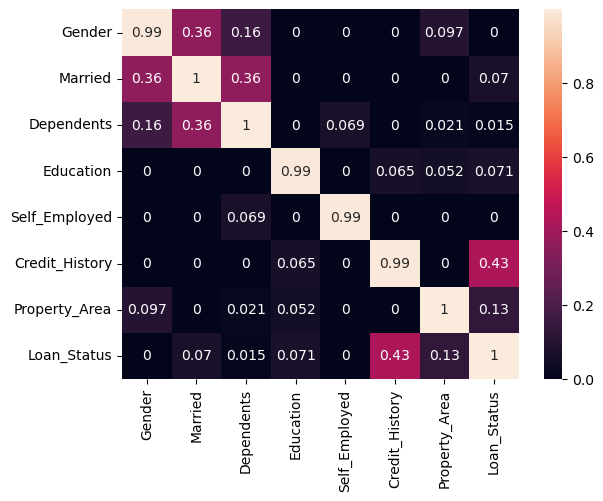

In [32]:
sns.heatmap(cramers_v_matrix, annot = True)

### Correlation Between Numerical Features and Target Variable

To assess the relationship between numerical features and the **binary target variable** (Loan_Status), we use the **Point Biserial Correlation**.

The **Point Biserial Correlation** measures the **strength and direction of association** between a **continuous numerical variable** and a **binary categorical variable**.  
It is a special case of the Pearson correlation and returns values between **–1 and +1**, similar to standard correlation coefficients.

In [34]:
df = train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Loan_Status', 'TotalIncome']]

df['Loan_Status'] = df['Loan_Status'].map({'Y':1, 'N':0})
    

/var/folders/pd/_qgptw4116qd3yy48lzsvp400000gn/T/ipykernel_4771/632964935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Loan_Status'] = df['Loan_Status'].map({'Y':1, 'N':0})


In [36]:

column_var = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'TotalIncome']
pointbiserial_results = {}

for var in column_var:
    stats, pval = pointbiserialr(df['Loan_Status'], df[var])
    pointbiserial_results[var] = stats

pointbiserial_df = pd.DataFrame.from_dict(pointbiserial_results, orient='index', columns=['PointBiserial_Correlation'])
pointbiserial_df

,PointBiserial_Correlation
ApplicantIncome,-0.004710
CoapplicantIncome,-0.059187
LoanAmount,-0.036893
Loan_Amount_Term,-0.022549
TotalIncome,-0.031271


All continuous variables are negatively related to Loan Status

In [37]:
# Removing the applicant income and coapplicant income, as I am using the total income 


train.drop(columns = ['ApplicantIncome', 'CoapplicantIncome'], axis = 1, inplace = True)

In [38]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,LP001002,Male,No,0,Graduate,No,147.0,360.0,1.0,Urban,Y,5849.0
1,LP001003,Male,Yes,1,Graduate,No,128.0,360.0,1.0,Rural,N,6091.0
2,LP001005,Male,Yes,0,Graduate,Yes,66.0,360.0,1.0,Urban,Y,3000.0
3,LP001006,Male,Yes,0,Not Graduate,No,120.0,360.0,1.0,Urban,Y,4941.0
4,LP001008,Male,No,0,Graduate,No,141.0,360.0,1.0,Urban,Y,6000.0


### Logistic Regression

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [40]:
# Target variable
y = train['Loan_Status']

# Drop Loan_ID
X = train.drop(['Loan_ID','Loan_Status'], axis=1)



In [41]:
y = y.map({'Y': 1, 'N': 0})


In [42]:
categorical_features = ['Married', 'Dependents', 'Education', 'Property_Area', 'Credit_History', 'Gender', 'Self_Employed']
numerical_features = ['LoanAmount', 'Loan_Amount_Term', 'TotalIncome']


In [43]:
# For categorical variables
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# For numerical variables
numerical_transformer = StandardScaler()

# Combine using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [44]:
# Create the full pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)  # stratify to maintain proportion of Y/N


In [46]:
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'TotalIncome']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Married', 'Dependents',
                                                   'Education', 'Property_Area',
                                                   'Credit_History', 'Gender',
                                                   'Self_Employed'])])),
                ('classifier', LogisticRegression())])

In [47]:
y_pred = clf.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.7805
              precision    recall  f1-score   support

           0       0.72      0.47      0.57        38
           1       0.80      0.92      0.85        85

    accuracy                           0.78       123
   macro avg       0.76      0.70      0.71       123
weighted avg       0.77      0.78      0.77       123

[[18 20]
 [ 7 78]]


### Interpretation of the Confusion Matrix

From the confusion matrix above, it is evident that the model struggles to correctly identify loan rejection cases.  
Specifically, only **47%** of the actual negative cases (applicants who should be rejected) are correctly classified.  
The remaining **53%** of these cases are incorrectly predicted as positive (approved).

This indicates that the model has a **bias towards predicting loan approvals**, which can largely be attributed to the **class imbalance** in the dataset.  
Since there are significantly more instances of the approved class compared to the rejected class, the model tends to favor predicting approvals, leading to poor performance in identifying rejections.

Addressing this imbalance — through techniques such as **resampling**, **smote** — can help improve the model's ability to correctly classify both classes.


### imbalanced to balanced data

In [48]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Oversampling using RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
print("Oversampled class distribution:", Counter(y_over))

Oversampled class distribution: Counter({1: 422, 0: 422})


In [49]:
X_over

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalIncome
0,Male,No,0,Graduate,No,147.0,360.0,1.0,Urban,5849.0
1,Male,Yes,1,Graduate,No,128.0,360.0,1.0,Rural,6091.0
2,Male,Yes,0,Graduate,Yes,66.0,360.0,1.0,Urban,3000.0
3,Male,Yes,0,Not Graduate,No,120.0,360.0,1.0,Urban,4941.0
4,Male,No,0,Graduate,No,141.0,360.0,1.0,Urban,6000.0
...,...,...,...,...,...,...,...,...,...,...
839,Male,No,0,Graduate,No,147.0,360.0,1.0,Semiurban,6767.0
840,Male,Yes,2,Graduate,Yes,147.0,360.0,0.0,Rural,6633.0
841,Male,Yes,0,Graduate,No,135.0,360.0,1.0,Rural,1950.0
842,Male,Yes,0,Not Graduate,No,116.0,360.0,0.0,Semiurban,4511.0


In [50]:
y_over

0      1
1      0
2      1
3      1
4      1
      ..
839    0
840    0
841    0
842    0
843    0
Name: Loan_Status, Length: 844, dtype: int64

In [51]:

categorical_features = ['Married', 'Dependents', 'Education', 'Property_Area', 'Credit_History', 'Gender', 'Self_Employed']
numerical_features = ['LoanAmount', 'Loan_Amount_Term', 'TotalIncome']


# For categorical variables
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# For numerical variables
numerical_transformer = StandardScaler()

# Combine using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y_over)  # stratify to maintain proportion of Y/N


clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.6627
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        85
           1       0.64      0.73      0.68        84

    accuracy                           0.66       169
   macro avg       0.67      0.66      0.66       169
weighted avg       0.67      0.66      0.66       169

[[51 34]
 [23 61]]


### Model Performance Evaluation (After Oversampling)

After applying **oversampling** to address class imbalance, the model achieved an **overall accuracy** of **70.41%**.

#### Class-wise performance:

- **Class 0 (Loan Rejected)**  
  - **Precision**: 0.75 → When the model predicts rejection, it is correct 75% of the time.  
  - **Recall**: 0.61 → The model correctly identifies 61% of actual rejections.  
  - **F1-score**: 0.68 → Balance between precision and recall.

- **Class 1 (Loan Approved)**  
  - **Precision**: 0.67 → When the model predicts approval, it is correct 67% of the time.  
  - **Recall**: 0.80 → The model correctly identifies 80% of actual approvals.  
  - **F1-score**: 0.73 → Indicates stronger performance on approvals compared to rejections.

#### Overall Insights

The model demonstrates **better recall** for approved cases (**80%**) compared to rejected cases (**61%**), suggesting that it is still more effective at identifying approvals than rejections — but the gap has narrowed compared to the pre-oversampling scenario.

The **macro average** and **weighted average** scores (~0.70) indicate **balanced performance** across both classes after oversampling, reflecting the benefit of balancing the dataset.

While oversampling has improved the model’s ability to recognize the minority class (rejections), further tuning or alternative techniques (e.g., smote) could help improve recall for class 0 even further.


### Using SMOTE

In [53]:
# applying the encoding tevhnique to 
X_transformed = preprocessor.fit_transform(X)


In [54]:
X_transformed

array([[ 0.00731161,  0.2732313 , -0.18218376, ...,  1.        ,
         1.        ,  0.        ],
       [-0.21894108,  0.2732313 , -0.14468416, ...,  1.        ,
         1.        ,  0.        ],
       [-0.95723935,  0.2732313 , -0.62365632, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 1.26956349,  0.2732313 ,  0.19947539, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.48363308,  0.2732313 ,  0.08651172, ...,  1.        ,
         1.        ,  0.        ],
       [-0.1594009 ,  0.2732313 , -0.37835935, ...,  0.        ,
         0.        ,  1.        ]])

In [55]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

In [59]:
len(y_resampled)

844

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y_resampled)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7337
              precision    recall  f1-score   support

           0       0.79      0.64      0.71        85
           1       0.69      0.83      0.76        84

    accuracy                           0.73       169
   macro avg       0.74      0.73      0.73       169
weighted avg       0.74      0.73      0.73       169

[[54 31]
 [14 70]]


### Model Performance Evaluation (After SMOTE)

After applying **SMOTE (Synthetic Minority Over-sampling Technique)** to balance the dataset, the model achieved an improved **accuracy** of **73.37%**.

### Class-wise performance:

- **Class 0 (Loan Rejected)**  
  - **Precision**: 0.79 → When the model predicts rejection, it is correct 79% of the time.  
  - **Recall**: 0.64 → The model correctly identifies 64% of actual rejections.  
  - **F1-score**: 0.71 → Reflects a good balance between precision and recall for rejections.

- **Class 1 (Loan Approved)**  
  - **Precision**: 0.69 → When the model predicts approval, it is correct 69% of the time.  
  - **Recall**: 0.83 → The model correctly identifies 83% of actual approvals.  
  - **F1-score**: 0.76 → Indicates strong performance on approvals.

### Overall Insights

The model shows **improved balance** between both classes compared to earlier results.  
While recall for **loan approvals (class 1)** remains high (**83%**), there is a notable improvement in precision for **loan rejections (class 0)** (**79%**). This means the model is not only identifying more rejections correctly but also making **more accurate rejection predictions**.

The **macro average** and **weighted average** metrics (~0.73) confirm a more balanced and reliable classification performance across both classes after applying SMOTE.

SMOTE has helped the model generalize better to both loan approval and rejection cases, reducing bias toward the majority class while maintaining robust predictive power.



## Predict the test data

In [123]:
test['Gender'] = test['Gender'].fillna(test['Gender'].mode()[0])
test['Married'] = test['Married'].fillna('No')
test['Dependents'] = test['Dependents'].fillna('0')
test['Self_Employed'] = test['Self_Employed'].fillna('No')
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0])
test['Credit_History'] = test['Credit_History'].fillna(0)
test['LoanAmount'] = test.apply(lambda row: loan_amount_term_dict.get(row['Loan_Amount_Term']) if pd.isna(row['LoanAmount']) else row['LoanAmount'],
    axis=1)


In [124]:
test_copy = test.copy()
test_copy['TotalIncome'] = test_copy['ApplicantIncome'] + test_copy['CoapplicantIncome']
test_copy.drop(columns = ['ApplicantIncome', 'CoapplicantIncome', 'Loan_ID'], axis = 1, inplace = True)

In [125]:
test_copy

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalIncome
0,Male,Yes,0,Graduate,No,110.0,360.0,1.0,Urban,5720
1,Male,Yes,1,Graduate,No,126.0,360.0,1.0,Urban,4576
2,Male,Yes,2,Graduate,No,208.0,360.0,1.0,Urban,6800
3,Male,Yes,2,Graduate,No,100.0,360.0,0.0,Urban,4886
4,Male,No,0,Not Graduate,No,78.0,360.0,1.0,Urban,3276
...,...,...,...,...,...,...,...,...,...,...
362,Male,Yes,3+,Not Graduate,Yes,113.0,360.0,1.0,Urban,5786
363,Male,Yes,0,Graduate,No,115.0,360.0,1.0,Urban,4867
364,Male,No,0,Graduate,No,126.0,360.0,0.0,Semiurban,5243
365,Male,Yes,0,Graduate,No,158.0,360.0,1.0,Rural,7393


In [126]:
X_test_transformed = preprocessor.fit_transform(test_copy)


In [127]:
y_test_pred = clf.predict(X_test_transformed)

In [128]:
test['predicted'] = y_test_pred

In [116]:
X_test_transformed

array([[-0.43187094,  0.26602207, -0.12618159, ...,  1.        ,
         1.        ,  0.        ],
       [-0.16905136,  0.26602207, -0.34650636, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.17789902,  0.26602207,  0.08181731, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-0.16905136,  0.26602207, -0.21804778, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.35658781,  0.26602207,  0.19602411, ...,  1.        ,
         1.        ,  0.        ],
       [-0.62898563, -2.52163936,  0.54403709, ...,  1.        ,
         0.        ,  1.        ]])

In [129]:
test['predicted'] = test['predicted'].map({1: 'Y', 0: 'N'})

In [130]:
test

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,predicted
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,Y
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,Y
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,Y
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,0.0,Urban,N
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban,Y
363,LP002975,Male,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban,Y
364,LP002980,Male,No,0,Graduate,No,3250,1993,126.0,360.0,0.0,Semiurban,N
365,LP002986,Male,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural,Y
